In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [2]:
# Read in the trip summary data
file_path = '../data/trip_summary_201901.csv'
trips = pd.read_csv(file_path)
trips = trips.dropna(how="any")

trips['start_station_id'].nunique()

152

In [3]:
# Create station pair identifiers and group the data

# Function: sorts the pair array and concatenates them to create a unique ID
def sort_concat(arr):
    arr_sorted = np.sort(arr)
    pair_id = str(arr_sorted[0]) + '_' + str(arr_sorted[1])
    
    return pair_id

pair_id = trips[['start_station_id', 'end_station_id']].values
pair_id_sorted = list(map(sort_concat, pair_id))

trips['station_pair_id'] = pair_id_sorted

In [4]:
# Create an affinity matrix from the data
pair_trips = trips.groupby('station_pair_id', as_index=False)['trip_count'].sum()
pair_trips['station_i'] = pair_trips['station_pair_id'].str.split("_", n = 1, expand = True)[0]
pair_trips['station_j'] = pair_trips['station_pair_id'].str.split("_", n = 1, expand = True)[1]
intercluster_volume = pair_trips
pair_trips['trip_count_inv'] = 1 / pair_trips['trip_count']

pair_trips['station_i'] = pd.to_numeric(pair_trips['station_i']).astype(np.int64)
pair_trips['station_j'] = pd.to_numeric(pair_trips['station_j']).astype(np.int64)

stations_sorted = pair_trips.sort_values(['station_i'])['station_i'].unique()
pair_trips = pair_trips.sort_values(['station_i'])


# Generate affinity matrix from pair_trips
upp_mat = pair_trips.set_index(['station_i','station_j'])['trip_count_inv'].unstack().values

aff_mat = np.triu(upp_mat) + np.triu(upp_mat, 1).T
aff_mat[np.isnan(aff_mat)] = 0

# Create an similarity matrix from the data
beta = 1
sim_mat = np.exp(-beta * aff_mat / aff_mat.std(ddof=0))

In [7]:
# Spectral clustering on the affinity matrix
from sklearn.cluster import SpectralClustering
from sklearn import metrics

i = 2
score_tracking = []
while i <= 10:

    sc = SpectralClustering(i, affinity='precomputed', n_init=100, assign_labels='discretize')
    clusters = sc.fit_predict(sim_mat)
    
    # select start station and trip count to new dataframe
    intercluster_volume = intercluster_volume[['station_i','station_j', 'trip_count']]

    #define a mapping dictionary
    cluster_dict = dict(zip(stations_sorted, clusters))

    # map the clusters to the starting stations
    intercluster_volume['cluster_i'] = intercluster_volume['station_i'].map(cluster_dict)
    intercluster_volume['cluster_j'] = intercluster_volume['station_j'].map(cluster_dict)

    intercluster_volume.loc[intercluster_volume.cluster_i == intercluster_volume.cluster_j, 'intercluster_trip'] = 0 
    intercluster_volume.loc[intercluster_volume.cluster_i != intercluster_volume.cluster_j, 'intercluster_trip'] = 1 

    intercluster_volume['intercluster_volume'] = intercluster_volume['intercluster_trip']*intercluster_volume['trip_count']
    
    score = metrics.silhouette_score(sim_mat, clusters)
    
    print('Number of clusters = ',i,'    volume =',intercluster_volume['intercluster_volume'].sum(), '    score  =', score)
    score_tracking.append([score, i, clusters])
    

    i = i + 1
    
best_cluster = score_tracking[score_tracking.index(max(score_tracking))][2]
num_clustes = score_tracking[score_tracking.index(max(score_tracking))][1]


Number of clusters =  2     volume = 37719.0     score  = 0.053761473371410545
Number of clusters =  3     volume = 58359.0     score  = 0.04527201258571525
Number of clusters =  4     volume = 73586.0     score  = 0.0218601924828472
Number of clusters =  5     volume = 85716.0     score  = 0.006335311662793748
Number of clusters =  6     volume = 89743.0     score  = -0.0003594316404565124
Number of clusters =  7     volume = 88056.0     score  = -0.006704237332936469
Number of clusters =  8     volume = 94446.0     score  = 0.011622667462253041
Number of clusters =  9     volume = 104891.0     score  = -0.00418999572635083
Number of clusters =  10     volume = 103235.0     score  = -0.00732052877491758


In [8]:
station_clustered = list(zip(stations_sorted, best_cluster))
df_station_clustered = pd.DataFrame(station_clustered)
df_station_clustered.rename(columns={0:'station_id',
                                    1: 'cluster'},inplace=True)

start = trips[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().rename(columns = {'start_station_id':'station_id', \
                                                 'start_station_name':'station_name', \
                                                 'start_station_latitude':'station_latitude', 
                                                 'start_station_longitude': 'station_longitude'})

end = trips[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']].drop_duplicates().rename(columns = {'end_station_id':'station_id', \
                                             'end_station_name':'station_name', \
                                             'end_station_latitude':'station_latitude', \
                                             'end_station_longitude': 'station_longitude'})

df_loc = pd.concat([start, end]).drop_duplicates()
df_all = df_loc.merge(df_station_clustered, on=["station_id"], how="right")
df_all.to_csv("df_station_clustered.csv", index=None)
df_all.head()

,station_id,station_name,station_latitude,station_longitude,cluster
0,109,17th St at Valencia St,37.763316,-122.421904,1
1,118,Eureka Valley Recreation Center,37.759177,-122.436943,1
2,119,18th St at Noe St,37.761047,-122.432642,1
3,120,Mission Dolores Park,37.761420,-122.426435,1
4,121,Mission Playground,37.759210,-122.421339,1


In [9]:
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

def plot_stations_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['station_latitude'])
    lon = list(stns['station_longitude'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['station_longitude']), list(df['station_latitude']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)
        

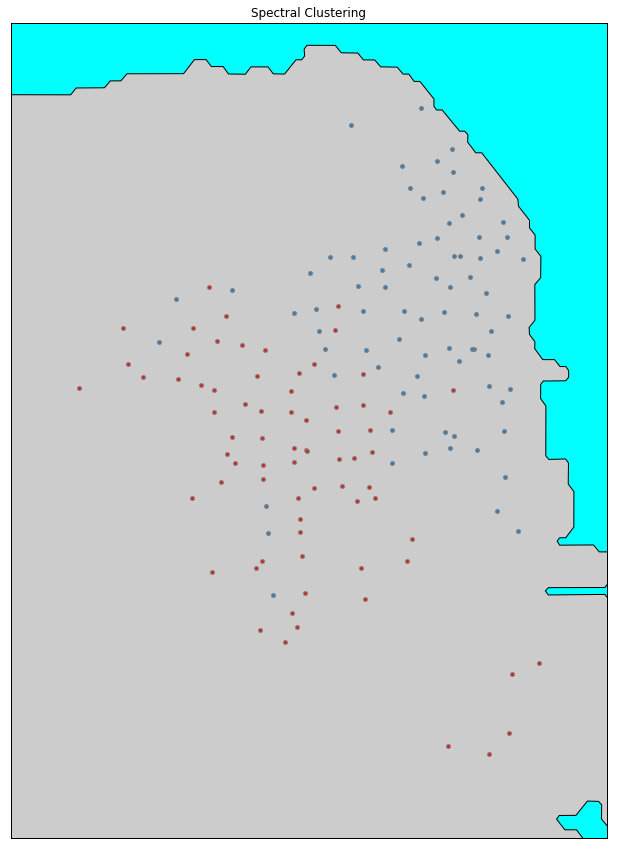

In [10]:
n = num_clustes
plt.subplots(nrows=1, ncols=n, figsize=(20,15))

ax = plt.subplot(1, 1, 1)
ax.set_title("Spectral Clustering")

plot_stations_map(ax, df_all)